# lib & data

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dropout, Dense
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dropout, Dense, Flatten
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from keras.optimizers import RMSprop
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.layers import LSTM

In [ ]:
train_data= pd.read_csv('/content/train_FD001.csv')
test_data = pd.read_csv('/content/test_FD001.csv')
RUL_data = pd.read_csv('/content/RUL_FD001.csv')

In [ ]:
print(f'train shape= {train_data.shape} \ntest  shape= {test_data.shape} ')

train shape= (20631, 27) 
test  shape= (13096, 27) 


# life time calculation

In [ ]:
life_times=[]
counter=0
for i in range(train_data.shape[0]):
  try:
    if train_data.iloc[i,1]!=train_data.iloc[i+1,1]:
      counter+=1
      life_times.append(train_data.iloc[i,2])
      train_data.at[i,'life_time']= life_times[-1]
      while counter>=0 :
        train_data.at[i-counter,'life_time']= life_times[-1]
        counter-=1
    else:
      counter+=1
  except:
    life_times.append(train_data.iloc[i,2])
    for j in range(i,int(life_times[-1]-1),-1):
      train_data.at[j,'life_time']= life_times[-1]
train_data=train_data.iloc[:-1,:]
for engine in range(len(life_times)):
  print(f'life time of engine Num.{engine+1}= {life_times[engine]}')

life time of engine Num.1= 192
life time of engine Num.2= 287.0
life time of engine Num.3= 179.0
life time of engine Num.4= 189.0
life time of engine Num.5= 269.0
life time of engine Num.6= 188.0
life time of engine Num.7= 259.0
life time of engine Num.8= 150.0
life time of engine Num.9= 201.0
life time of engine Num.10= 222.0
life time of engine Num.11= 240.0
life time of engine Num.12= 170.0
life time of engine Num.13= 163.0
life time of engine Num.14= 180.0
life time of engine Num.15= 207.0
life time of engine Num.16= 209.0
life time of engine Num.17= 276.0
life time of engine Num.18= 195.0
life time of engine Num.19= 158.0
life time of engine Num.20= 234.0
life time of engine Num.21= 195.0
life time of engine Num.22= 202.0
life time of engine Num.23= 168.0
life time of engine Num.24= 147.0
life time of engine Num.25= 230.0
life time of engine Num.26= 199.0
life time of engine Num.27= 156.0
life time of engine Num.28= 165.0
life time of engine Num.29= 163.0
life time of engine Num.3

In [ ]:
train_data['RUL']= train_data['life_time']-train_data['time in cycles']
train_data['RUL'] = [130 if x > 130 else x for x in train_data['RUL']]

<ipython-input-11-982d31dc3eb1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['RUL']= train_data['life_time']-train_data['time in cycles']
<ipython-input-11-982d31dc3eb1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['RUL'] = [130 if x > 130 else x for x in train_data['RUL']]


In [ ]:
train_data.columns

Index(['Unnamed: 0', 'unit number', 'time in cycles', 'operational setting 1',
       'operational setting 2', 'operational setting 3',
       'sensor measurement 1', 'sensor measurement 2', 'sensor measurement 3',
       'sensor measurement 4', 'sensor measurement 5', 'sensor measurement 6',
       'sensor measurement 7', 'sensor measurement 8', 'sensor measurement 9',
       'sensor measurement 10', 'sensor measurement 11',
       'sensor measurement 12', 'sensor measurement 13',
       'sensor measurement 14', 'sensor measurement 15',
       'sensor measurement 16', 'sensor measurement 17',
       'sensor measurement 18', 'sensor measurement 19',
       'sensor measurement 20', 'sensor measurement 21', 'life_time'],
      dtype='object')

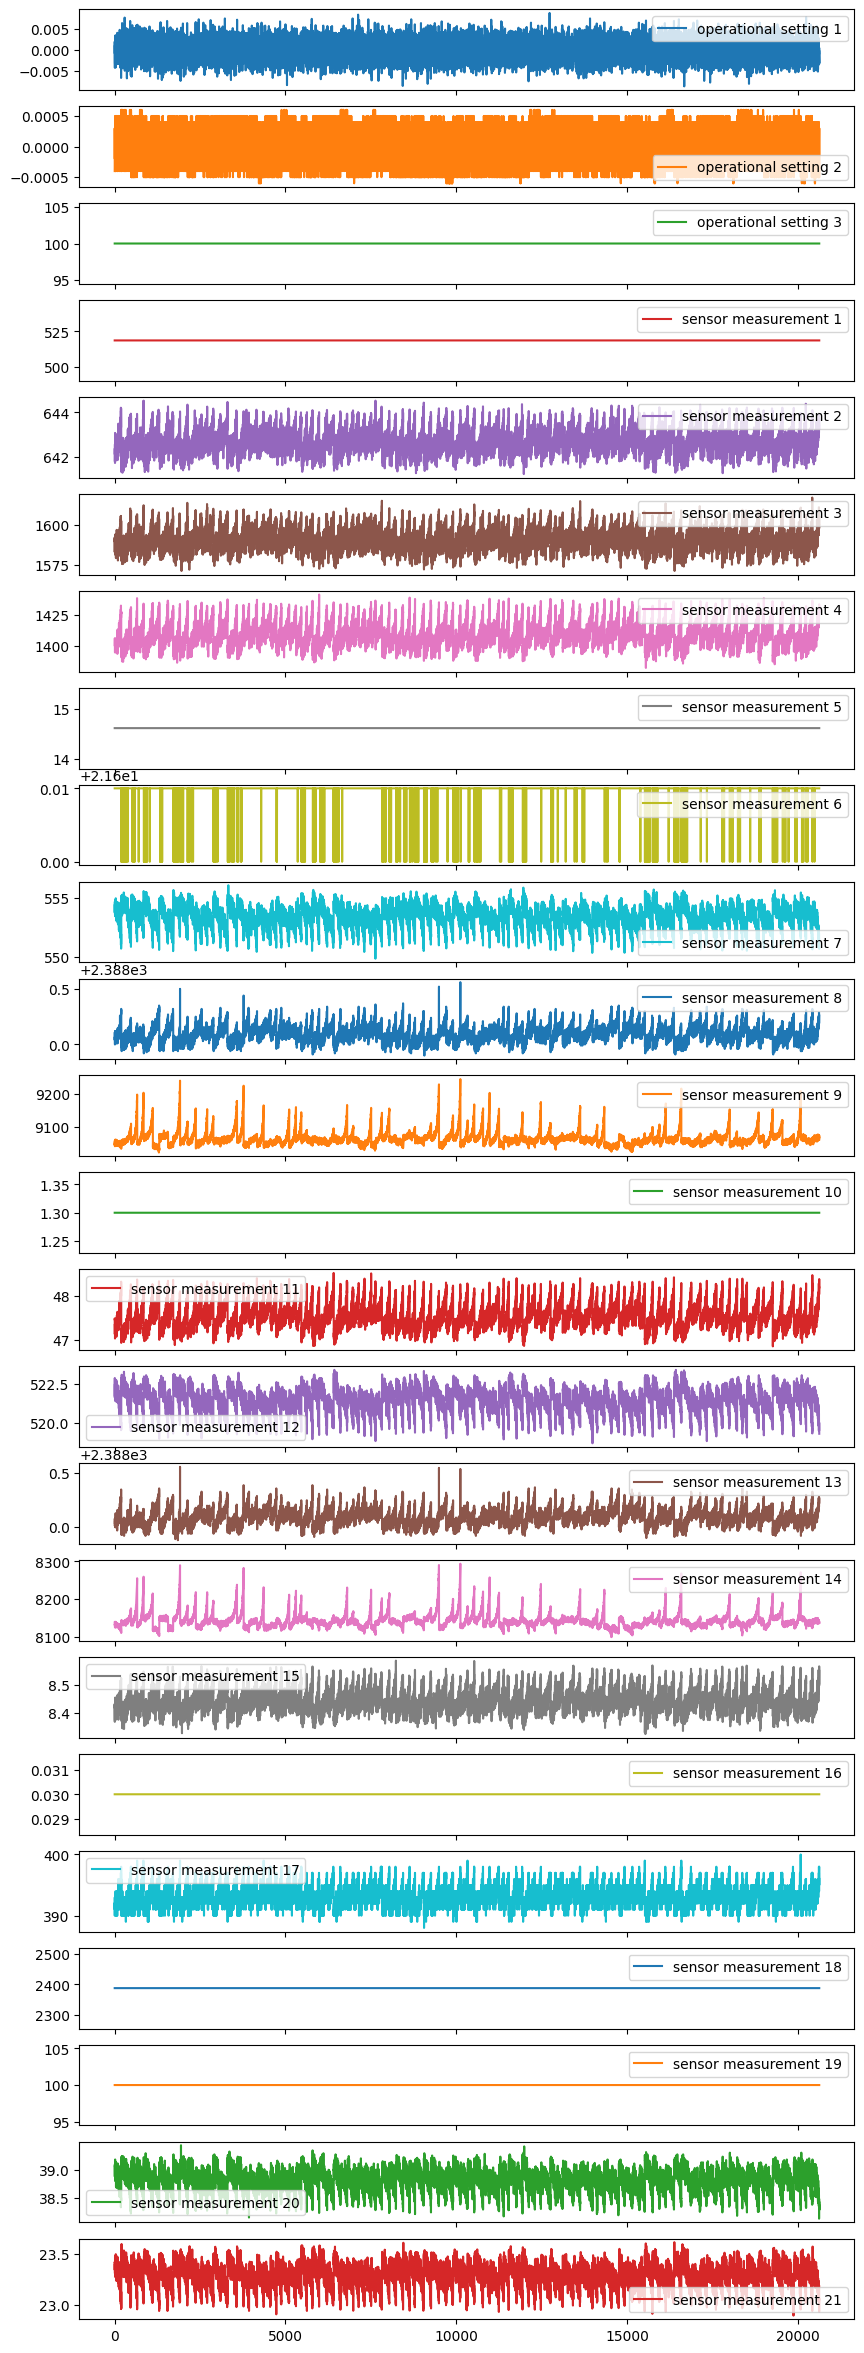

In [ ]:
train_data.iloc[:,3:27].plot(subplots=True,figsize=(10, 30))
plt.show()

# Data Selection

omit these:
'operational setting 3',
       'sensor measurement 1'
, 'sensor measurement 5'
 'sensor measurement 10'
 'sensor measurement 16'
       'sensor measurement 18', 'sensor measurement 19',
:

In [ ]:
FF=['operational setting 1','operational setting 2', 'sensor measurement 2','sensor measurement 3',
       'sensor measurement 4', 'sensor measurement 6','sensor measurement 7', 'sensor measurement 8', 'sensor measurement 9',
       'sensor measurement 11','sensor measurement 12', 'sensor measurement 13',
       'sensor measurement 14', 'sensor measurement 15',
       'sensor measurement 17','sensor measurement 20','sensor measurement 21', 'RUL']
train2 = train_data.loc[:, FF]
RUL=pd.read_csv('/content/RUL_FD001.csv')
RUL.set_index('unit number', inplace=True)
RUL.head()
max_cycle_test = test_data.groupby('unit number')['time in cycles'].max()
total_cycles = RUL['RUL'] + max_cycle_test
test_data['RUL'] = test_data['unit number'].apply(lambda x: total_cycles.loc[x]) - test_data['time in cycles']
#train['RUL'] = train['RUL'].clip(upper=130)
test_data['RUL'] = test_data['RUL'].clip(upper=130)
#test_data['RUL'] = test_data['RUL'].clip(upper=130)
test2 = test_data.loc[:, FF[:-1]]

In [ ]:
test2.shape

(13096, 17)

In [ ]:
test_data.iloc[:10,:]

,Unnamed: 0,unit number,time in cycles,operational setting 1,operational setting 2,operational setting 3,sensor measurement 1,sensor measurement 2,sensor measurement 3,sensor measurement 4,...,sensor measurement 13,sensor measurement 14,sensor measurement 15,sensor measurement 16,sensor measurement 17,sensor measurement 18,sensor measurement 19,sensor measurement 20,sensor measurement 21,RUL
0,0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,...,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,130
1,1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,...,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,130
2,2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,...,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,130
3,3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,...,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,130
4,4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,...,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,130
5,5,1,6,0.0012,0.0003,100.0,518.67,642.11,1579.12,1395.13,...,2388.08,8127.46,8.4238,0.03,392,2388,100.0,38.91,23.3467,130
6,6,1,7,-0.0000,0.0002,100.0,518.67,642.11,1583.34,1404.84,...,2388.06,8134.97,8.3914,0.03,391,2388,100.0,38.85,23.3952,130
7,7,1,8,0.0006,-0.0000,100.0,518.67,642.54,1580.89,1400.89,...,2388.06,8125.93,8.4213,0.03,393,2388,100.0,39.05,23.3224,130
8,8,1,9,-0.0036,0.0000,100.0,518.67,641.88,1593.29,1412.28,...,2388.05,8134.15,8.4353,0.03,391,2388,100.0,39.10,23.4521,130
9,9,1,10,-0.0025,-0.0001,100.0,518.67,642.07,1585.25,1398.64,...,2388.06,8134.08,8.4093,0.03,391,2388,100.0,38.87,23.3820,130


# Data Normalization

In [ ]:
scaler = MinMaxScaler()
train2_normalized = train2.copy()
test2_normalized = test2.copy()
Features=['operational setting 1','operational setting 2', 'sensor measurement 2','sensor measurement 3',
       'sensor measurement 4', 'sensor measurement 6','sensor measurement 7', 'sensor measurement 8', 'sensor measurement 9',
       'sensor measurement 11','sensor measurement 12', 'sensor measurement 13',
       'sensor measurement 14', 'sensor measurement 15',
       'sensor measurement 17','sensor measurement 20','sensor measurement 21', 'RUL']
for c in Features:
    train2_normalized.loc[:,c] = scaler.fit_transform(train2.loc[:,c].values.reshape(-1, 1))
for c in Features[:-1]:
    test2_normalized.loc[:,c] = scaler.fit_transform(test2.loc[:,c].values.reshape(-1, 1))

In [ ]:
test2.shape

(13096, 17)

# Data Labeling

In [ ]:
train_data['life_time'].unique()

array([192., 287., 179., 189., 269., 188., 259., 150., 201., 222., 240.,
       170., 163., 180., 207., 209., 276., 195., 158., 234., 202., 168.,
       147., 230., 199., 156., 165., 194., 191., 200., 181., 128., 216.,
       196., 256., 214., 231., 215., 198., 213., 257., 193., 275., 137.,
       172., 185., 174., 283., 153., 313., 362., 208., 166., 229., 210.,
       154., 293., 267., 278., 178., 217., 135., 341., 155., 258., 336.])

In [ ]:
train2['RUL'].unique()

array([130., 129., 128., 127., 126., 125., 124., 123., 122., 121., 120.,
       119., 118., 117., 116., 115., 114., 113., 112., 111., 110., 109.,
       108., 107., 106., 105., 104., 103., 102., 101., 100.,  99.,  98.,
        97.,  96.,  95.,  94.,  93.,  92.,  91.,  90.,  89.,  88.,  87.,
        86.,  85.,  84.,  83.,  82.,  81.,  80.,  79.,  78.,  77.,  76.,
        75.,  74.,  73.,  72.,  71.,  70.,  69.,  68.,  67.,  66.,  65.,
        64.,  63.,  62.,  61.,  60.,  59.,  58.,  57.,  56.,  55.,  54.,
        53.,  52.,  51.,  50.,  49.,  48.,  47.,  46.,  45.,  44.,  43.,
        42.,  41.,  40.,  39.,  38.,  37.,  36.,  35.,  34.,  33.,  32.,
        31.,  30.,  29.,  28.,  27.,  26.,  25.,  24.,  23.,  22.,  21.,
        20.,  19.,  18.,  17.,  16.,  15.,  14.,  13.,  12.,  11.,  10.,
         9.,   8.,   7.,   6.,   5.,   4.,   3.,   2.,   1.,   0.])

# Time Windows

In [ ]:
train2_normalized.columns

Index(['operational setting 1', 'operational setting 2',
       'sensor measurement 2', 'sensor measurement 3', 'sensor measurement 4',
       'sensor measurement 6', 'sensor measurement 7', 'sensor measurement 8',
       'sensor measurement 9', 'sensor measurement 11',
       'sensor measurement 12', 'sensor measurement 13',
       'sensor measurement 14', 'sensor measurement 15',
       'sensor measurement 17', 'sensor measurement 20',
       'sensor measurement 21', 'RUL'],
      dtype='object')

In [ ]:
X=[]
y_reg=[] # label for Regression to predict RUL
y_cl=[]  # label for Classification to predict healthy(0) vs. failure(1)
SEQ_LEN =30 #Sequence length(NL)
for i in range(SEQ_LEN,train2_normalized.shape[0]):
  X.append(train2_normalized.iloc[i-SEQ_LEN:i,:-1])
  y_reg.append(train2_normalized.at[i,'RUL'])
  tar= 0 if train2.at[i,'RUL'] > SEQ_LEN    else 1
  y_cl.append(tar)
X=np.array(X)
y_reg=np.array(y_reg)
y_cl=np.array(y_cl)

In [ ]:
xx_test=[]
y_reg_t=[] # label for Regression to predict RUL
y_cl_t=[]  # label for Classification to predict healthy(0) vs. failure(1)
SEQ_LEN =30 #Sequence length(NL)
for i in range(SEQ_LEN,test2_normalized.shape[0]):
  xx_test.append(test2_normalized.iloc[i-SEQ_LEN:i,:])
  y_reg_t.append(test_data.at[i,'RUL'])
  tar= 0 if test_data.at[i,'RUL'] > SEQ_LEN    else 1
  y_cl_t.append(tar)
xx_test=np.array(xx_test)
y_reg_t=np.array(y_reg_t)
y_cl_t=np.array(y_cl_t)

In [ ]:
xx_test.shape

(13066, 30, 17)

In [ ]:
X.shape

(20601, 30, 17)

In [ ]:
print('X.shape : ',X.shape,'\nY.shape : ',y_reg.shape)

X.shape :  (20601, 30, 17) 
Y.shape :  (20601,)


# **Proposed Model**

# **classification**


In [ ]:
model_cl = Sequential()

model_cl.add(Conv1D(filters=32, kernel_size=5, activation='relu', input_shape=X.shape[1:]))
model_cl.add(Conv1D(filters=64, kernel_size=3, activation='relu'))

model_cl.add(MaxPooling1D(pool_size=3))

model_cl.add(LSTM(units=50, return_sequences=True))
model_cl.add(Dropout(rate=0.2))
model_cl.add(LSTM(units=50))
model_cl.add(Dropout(rate=0.2))
model_cl.add(Dense(units=1, activation='sigmoid'))

model_cl.compile(optimizer=Adam(), loss='binary_crossentropy')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


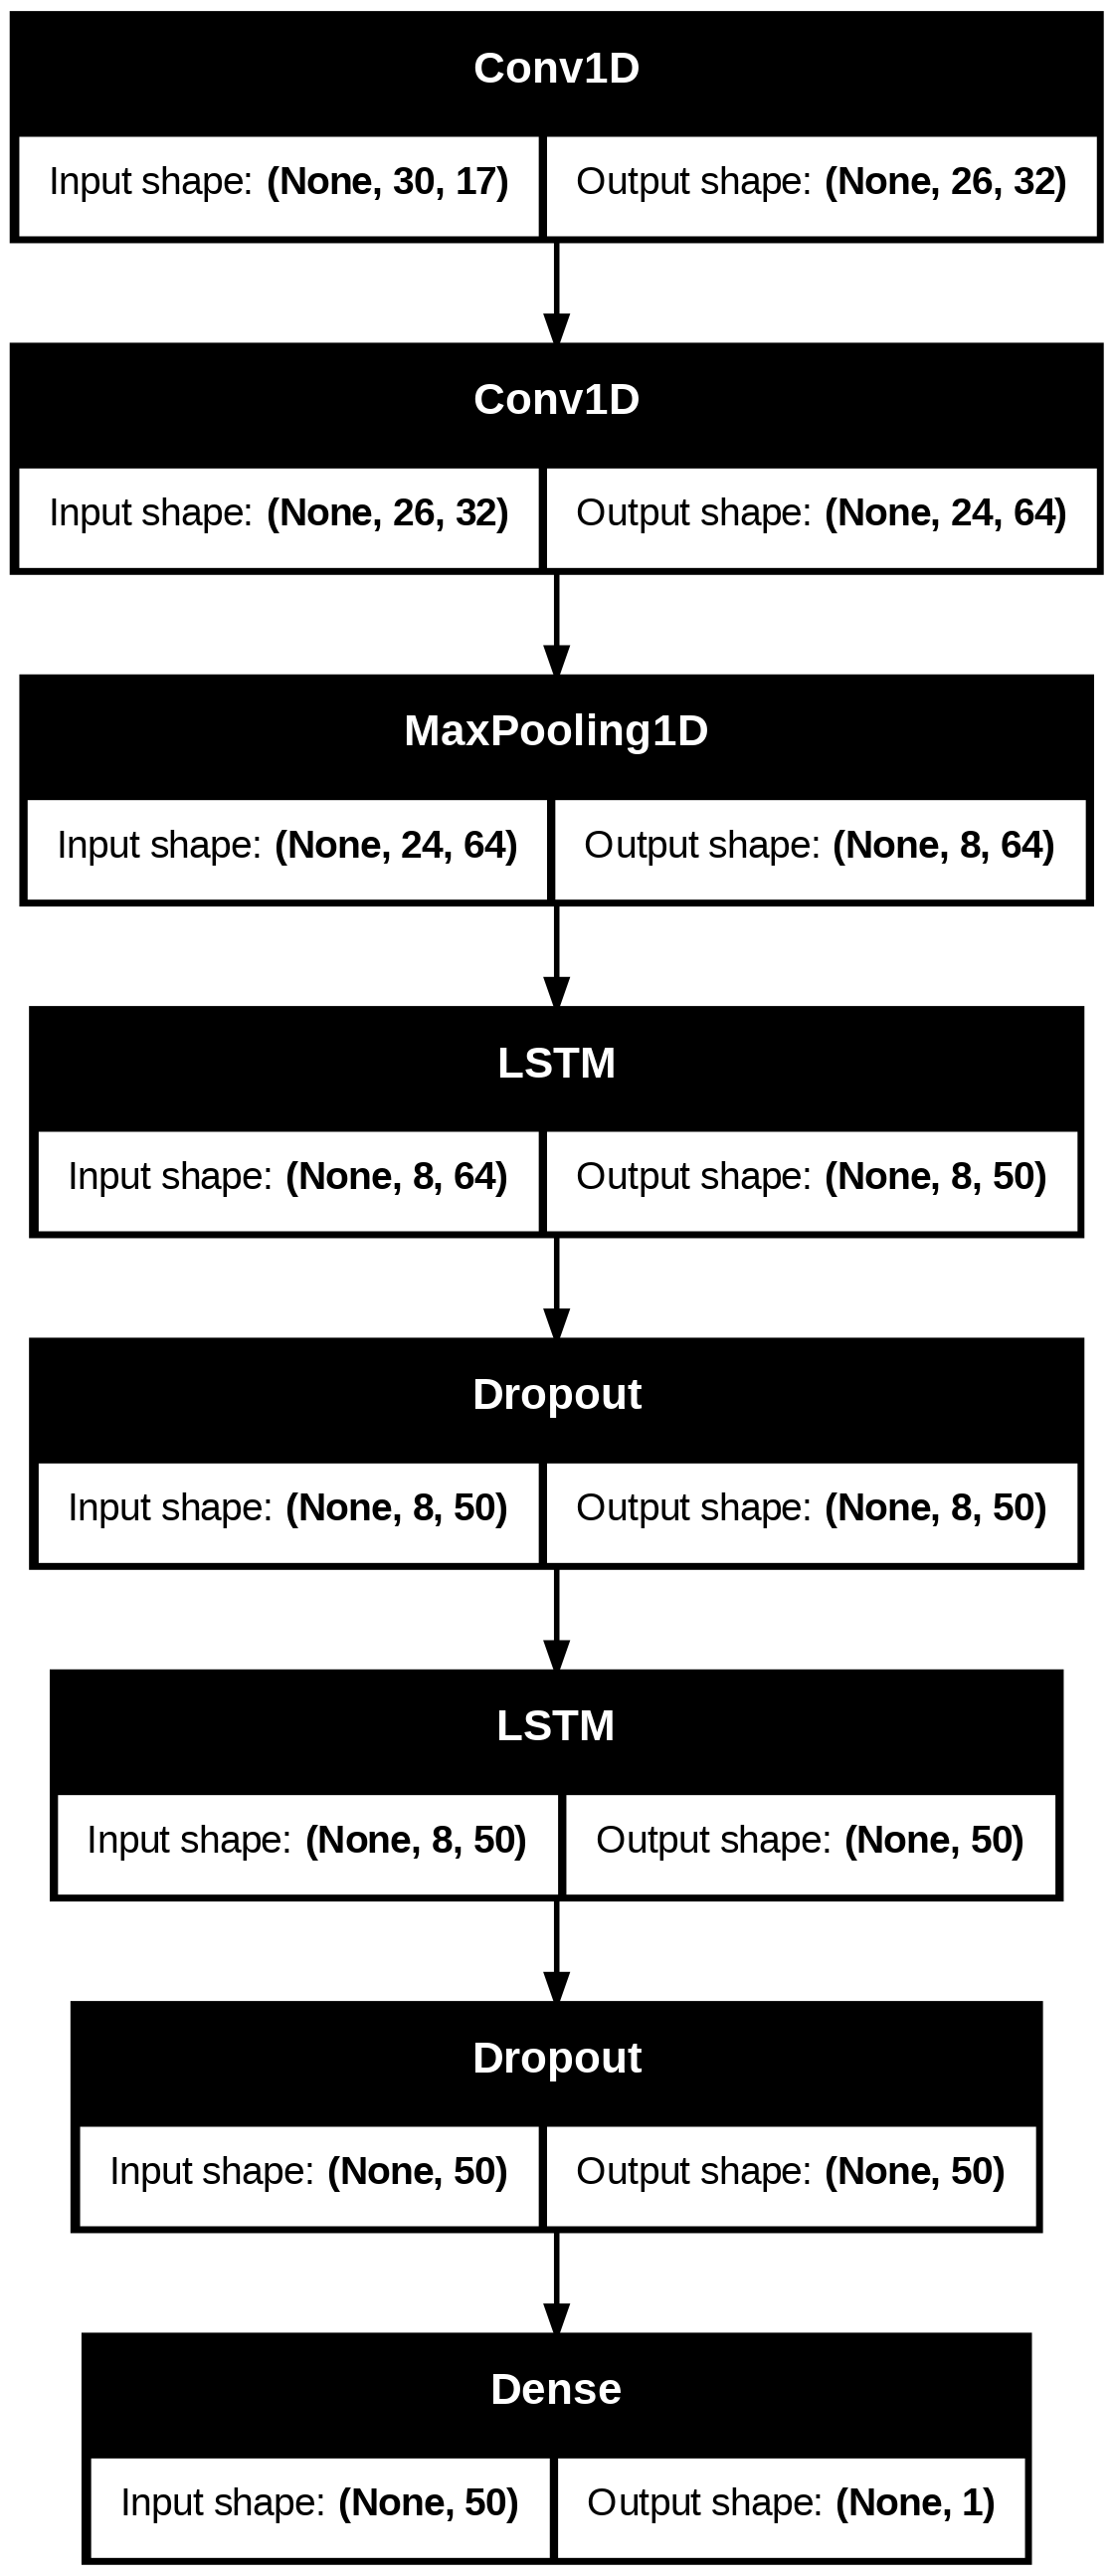

In [ ]:
tf.keras.utils.plot_model(model=model_cl, show_shapes=True)

# **Without Early Stopping**

In [ ]:
history_woes_cl = model_cl.fit(X, y_cl, epochs=100, validation_split=0.1)

Epoch 1/100
580/580 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.2844 - val_loss: 0.1313
Epoch 2/100
580/580 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.1142 - val_loss: 0.1036
Epoch 3/100
580/580 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0945 - val_loss: 0.0996
Epoch 4/100
580/580 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0809 - val_loss: 0.0904
Epoch 5/100
580/580 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0777 - val_loss: 0.1032
Epoch 6/100
580/580 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0765 - val_loss: 0.1236
Epoch 7/100
580/580 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0656 - val_loss: 0.0911
Epoch 8/100
580/580 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0604 - val_loss: 0.1010
Epoch 9/100
580/580 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0618 - val_loss: 0.1200
Epoch 10/100
580/580 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0504 - val_loss: 0.1094
Epoch 11/100
580/580 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0441 - val_loss: 0.0926
Epoch 12/100
580/580 ━━━━━━━━━━━━━━━━━━━

In [ ]:
xx_test.shape

(13066, 30, 17)

In [ ]:
y_pred = model_cl.predict(xx_test)
y_pred_bin = [1 if y > 0.5 else 0 for y in y_pred]
print(classification_report(y_cl_t, y_pred_bin))

409/409 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
              precision    recall  f1-score   support

           0       0.99      0.92      0.95     12734
           1       0.19      0.75      0.31       332

    accuracy                           0.91     13066
   macro avg       0.59      0.83      0.63     13066
weighted avg       0.97      0.91      0.94     13066



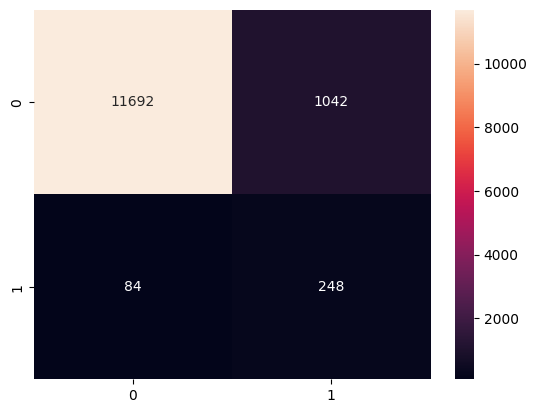

In [ ]:
cm = confusion_matrix(y_cl_t, y_pred_bin)

sns.heatmap(cm, annot=True, fmt='d')
plt.show()

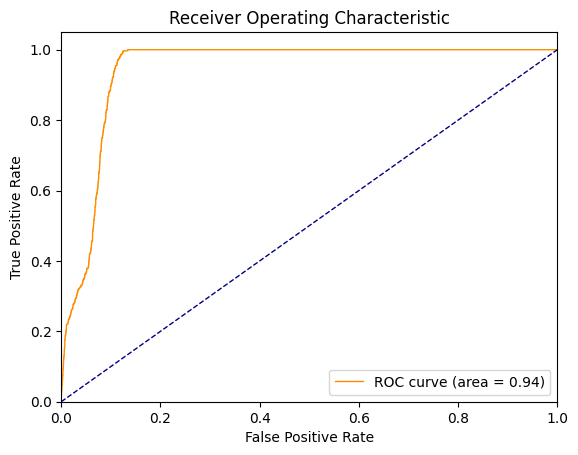

In [ ]:
fpr, tpr, thresholds = roc_curve(y_cl_t, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# **With Early Stopping**

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
history_wes= model_cl.fit(X, y_cl, epochs=100, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/100
580/580 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0072 - val_loss: 0.2903
Epoch 2/100
580/580 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0133 - val_loss: 0.2132
Epoch 3/100
580/580 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0058 - val_loss: 0.2248
Epoch 4/100
580/580 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0050 - val_loss: 0.2681
Epoch 5/100
580/580 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0071 - val_loss: 0.2453
Epoch 6/100
580/580 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0056 - val_loss: 0.2455
Epoch 7/100
580/580 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0078 - val_loss: 0.2337
Epoch 8/100
580/580 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0076 - val_loss: 0.2286
Epoch 9/100
580/580 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0078 - val_loss: 0.2967
Epoch 10/100
580/580 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0055 - val_loss: 0.2706
Epoch 11/100
580/580 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0097 - val_loss: 0.2343
Epoch 12/100
580/580 ━━━━━━━━━━━━━━━━━━━━

In [ ]:
y_pred =model_cl.predict(xx_test)
y_pred_bin = [1 if y > 0.5 else 0 for y in y_pred]
#print(classification_report(Y_test, y_pred_bin))
print(classification_report(y_cl_t, y_pred_bin))

409/409 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
              precision    recall  f1-score   support

           0       0.99      0.90      0.95     12734
           1       0.16      0.69      0.26       332

    accuracy                           0.90     13066
   macro avg       0.57      0.80      0.60     13066
weighted avg       0.97      0.90      0.93     13066



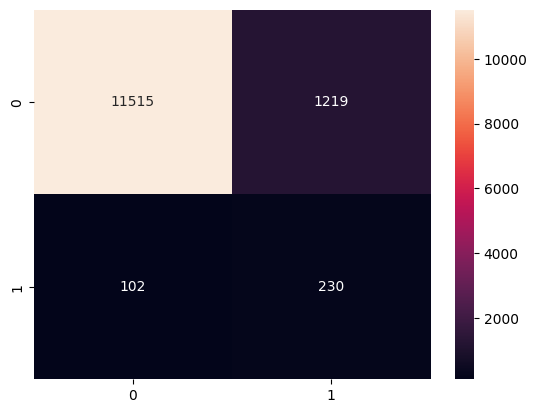

In [ ]:
cm = confusion_matrix(y_cl_t, y_pred_bin)

sns.heatmap(cm, annot=True, fmt='d')
plt.show()

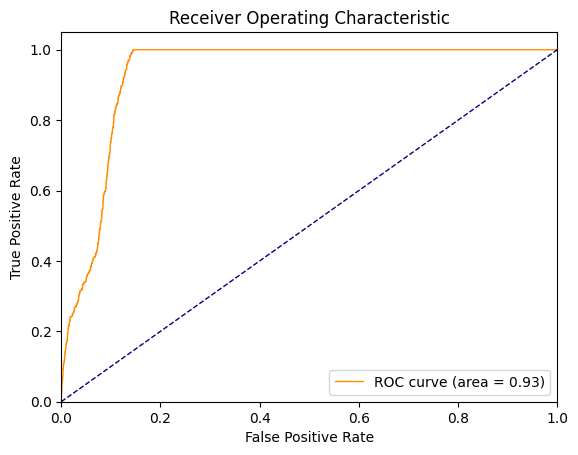

In [ ]:
fpr, tpr, thresholds = roc_curve(y_cl_t, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# **Regression**

In [ ]:
model_reg = Sequential()

model_reg.add(Conv1D(filters=32, kernel_size=5, activation='relu', input_shape=X.shape[1:]))
model_reg.add(Conv1D(filters=64, kernel_size=3, activation='relu'))

model_reg.add(MaxPooling1D(pool_size=3))

model_reg.add(LSTM(units=50, return_sequences=True))
model_reg.add(Dropout(rate=0.2))
model_reg.add(LSTM(units=50))
model_reg.add(Dropout(rate=0.2))

model_reg.add(Dense(units=1, activation='linear'))

model_reg.compile(optimizer=RMSprop(), loss='mean_squared_error', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
tf.keras.utils.plot_model(model=model_reg, show_shapes=True)

# **Without Early Stopping**

In [ ]:
history = model_reg.fit(X, y_reg, epochs=100, validation_split=0.1)

Epoch 1/100
580/580 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.3290 - loss: 0.0833 - val_accuracy: 0.4304 - val_loss: 0.0321
Epoch 2/100
580/580 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.3529 - loss: 0.0368 - val_accuracy: 0.4328 - val_loss: 0.0258
Epoch 3/100
580/580 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.3591 - loss: 0.0282 - val_accuracy: 0.4328 - val_loss: 0.0189
Epoch 4/100
580/580 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.3638 - loss: 0.0245 - val_accuracy: 0.4328 - val_loss: 0.0181
Epoch 5/100
580/580 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.3632 - loss: 0.0219 - val_accuracy: 0.4328 - val_loss: 0.0175
Epoch 6/100
580/580 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.3647 - loss: 0.0217 - val_accuracy: 0.4328 - val_loss: 0.0209
Epoch 7/100
580/580 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.3570 - loss: 0.0197 - val_accuracy: 0.4328 - val_loss: 0.0230
Epoch 8/100
580/580 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.3618 - loss: 0.0193 - val_accu

In [ ]:
y_reg_t_reshaped = np.array(y_reg_t).reshape(-1, 1)
y_reg_t1 = scaler.fit_transform(y_reg_t_reshaped)

In [ ]:
y_pred = model_reg.predict(xx_test)
mse = mean_squared_error(y_reg_t1, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_reg_t1, y_pred)
mape = np.mean(np.abs((y_reg_t1 - y_pred) / y_reg_t)) * 100
print(f'MSE: {mse}, \nRMSE: {rmse}, \nMAE: {mae}, \nMAPE: {mape}%')

409/409 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
MSE: 0.12745198160522445, 
RMSE: 0.3570041758932582, 
MAE: 0.28646467237396867, 
MAPE: 0.3059437222906943%


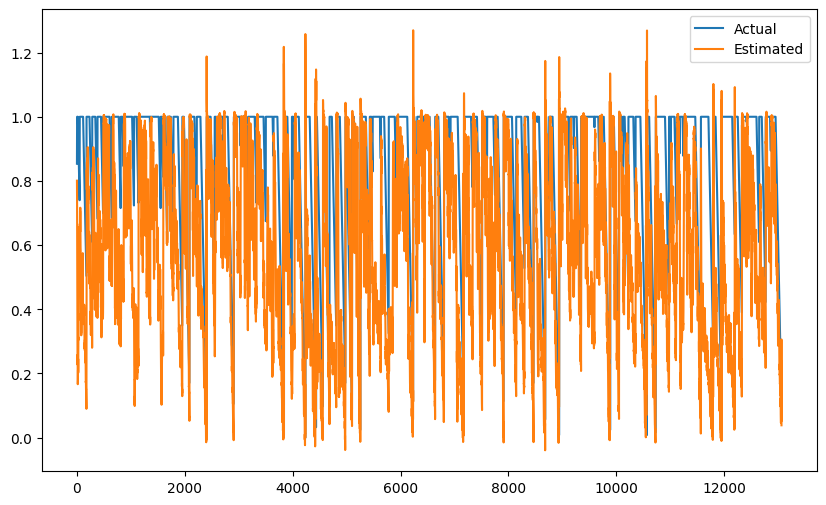

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(y_reg_t1, label='Actual')
plt.plot(y_pred, label='Estimated')
plt.legend()
plt.show()

# **With Early Stopping**

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
model_reg.fit(X, y_reg, epochs=100, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/100
580/580 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.3664 - loss: 0.0027 - val_accuracy: 0.4313 - val_loss: 0.0244
Epoch 2/100
580/580 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.3662 - loss: 0.0024 - val_accuracy: 0.4323 - val_loss: 0.0224
Epoch 3/100
580/580 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.3720 - loss: 0.0026 - val_accuracy: 0.4309 - val_loss: 0.0282
Epoch 4/100
580/580 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.3712 - loss: 0.0028 - val_accuracy: 0.4318 - val_loss: 0.0248
Epoch 5/100
580/580 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.3687 - loss: 0.0024 - val_accuracy: 0.4318 - val_loss: 0.0242
Epoch 6/100
580/580 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.3657 - loss: 0.0025 - val_accuracy: 0.4304 - val_loss: 0.0309
Epoch 7/100
580/580 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.3621 - loss: 0.0024 - val_accuracy: 0.4304 - val_loss: 0.0256
Epoch 8/100
580/580 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.3654 - loss: 0.0025 - val_accu

In [ ]:
y_pred = model_reg.predict(xx_test)
mse = mean_squared_error(y_reg_t1, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_reg_t1, y_pred)
mape = np.mean(np.abs((y_reg_t1 - y_pred) / y_reg_t1)) * 100

print(f'MSE: {mse}, RMSE: {rmse}, MAE: {mae}, MAPE: {mape}%')

409/409 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
MSE: 0.11878733203785996, RMSE: 0.34465538155940634, MAE: 0.27589188000041354, MAPE: inf%


<ipython-input-106-2dc51b109950>:5: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_reg_t1 - y_pred) / y_reg_t1)) * 100


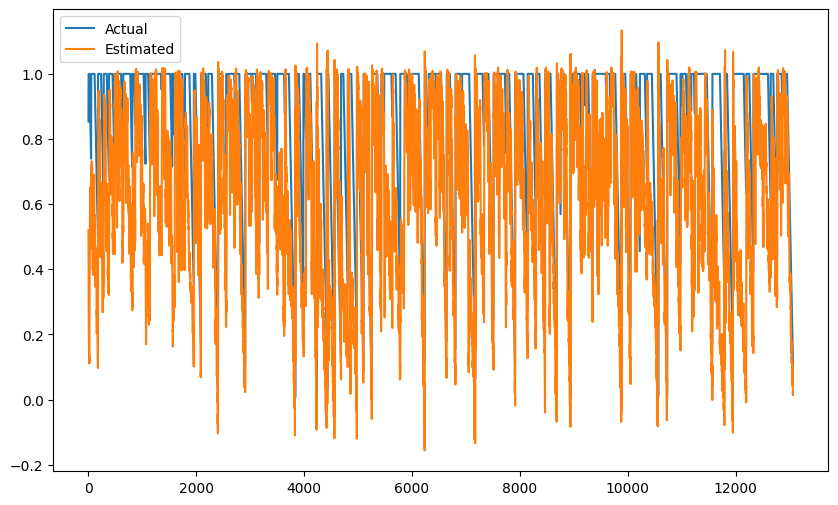

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(y_reg_t1, label='Actual')
plt.plot(y_pred, label='Estimated')
plt.legend()
plt.show()

# **Q3**

# **CNN**

# **CNN**

# **Regression**

In [ ]:
CNN_REG = Sequential()

CNN_REG.add(Conv1D(filters=8, kernel_size=6, activation='relu', input_shape=(30, 17)))
CNN_REG.add(MaxPooling1D(pool_size=4))
CNN_REG.add(Conv1D(filters=14, kernel_size=3, activation='relu'))
CNN_REG.add(MaxPooling1D(pool_size=2))

CNN_REG.add(Flatten())

CNN_REG.add(Dense(units=50, activation='relu'))
CNN_REG.add(Dense(units=10, activation='relu'))

CNN_REG.add(Dense(units=1, activation='linear'))

In [ ]:
CNN_REG.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 25, 8)             824       
                                                                 
 max_pooling1d (MaxPooling1  (None, 6, 8)              0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 4, 14)             350       
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 2, 14)             0         
 g1D)                                                            
                                                                 
 flatten (Flatten)           (None, 28)                0         
                                                                 
 dense (Dense)               (None, 50)                1

In [ ]:
CNN_REG.compile(optimizer=RMSprop(), loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

CNN_REG.fit(X, y_reg, epochs=100, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/100
580/580 [==============================] - 2s 3ms/step - loss: 1825.4456 - val_loss: 775.5432
Epoch 2/100
580/580 [==============================] - 1s 3ms/step - loss: 726.2697 - val_loss: 585.7004
Epoch 3/100
580/580 [==============================] - 2s 3ms/step - loss: 625.4914 - val_loss: 654.8614
Epoch 4/100
580/580 [==============================] - 2s 3ms/step - loss: 572.6741 - val_loss: 507.6467
Epoch 5/100
580/580 [==============================] - 2s 3ms/step - loss: 528.5041 - val_loss: 483.1344
Epoch 6/100
580/580 [==============================] - 2s 3ms/step - loss: 488.4236 - val_loss: 613.6052
Epoch 7/100
580/580 [==============================] - 2s 3ms/step - loss: 455.1490 - val_loss: 424.8377
Epoch 8/100
580/580 [==============================] - 2s 3ms/step - loss: 416.2445 - val_loss: 377.9783
Epoch 9/100
580/580 [==============================] - 2s 3ms/step - loss: 377.3022 - val_loss: 368.8805
Epoch 10/100
580/580 [==============================] 

In [ ]:
y_pred = model_cnn.predict(xx_test)
mse = mean_squared_error(y_reg_t, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_reg_t, y_pred)
mape = np.mean(np.abs((y_reg_t - y_pred) / y_reg_t)) * 100
print(f'MSE: {mse}, RMSE: {rmse}, MAE: {mae}, MAPE: {mape}%')

409/409 [==============================] - 1s 2ms/step
MSE: 1240.859497959224, RMSE: 35.22583566019725, MAE: 25.886679496185604, MAPE: 24.776857028177908%


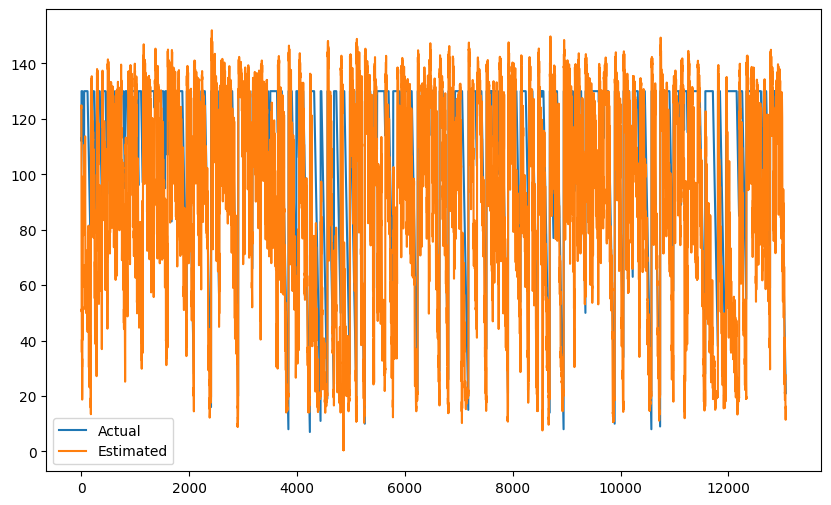

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(y_reg_t, label='Actual')
plt.plot(y_pred, label='Estimated')
plt.legend()
plt.show()

# **Classification**

# **Classification**

In [ ]:
CNN_CLA = Sequential()

CNN_CLA.add(Conv1D(filters=8, kernel_size=6, activation='relu', input_shape=(30, 17)))
CNN_CLA.add(MaxPooling1D(pool_size=4))
CNN_CLA.add(Conv1D(filters=14, kernel_size=3, activation='relu'))
CNN_CLA.add(MaxPooling1D(pool_size=2))

CNN_CLA.add(Flatten())

CNN_CLA.add(Dense(units=50, activation='relu'))
CNN_CLA.add(Dense(units=10, activation='relu'))

CNN_CLA.add(Dense(units=1, activation='sigmoid'))

In [ ]:
CNN_CLA.compile(optimizer=RMSprop(), loss='binary_crossentropy')
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

CNN_CLA.fit(X, y_cl, epochs=100, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/100
580/580 [==============================] - 2s 3ms/step - loss: 0.2145 - val_loss: 0.1866
Epoch 2/100
580/580 [==============================] - 2s 3ms/step - loss: 0.1388 - val_loss: 0.1248
Epoch 3/100
580/580 [==============================] - 2s 3ms/step - loss: 0.1125 - val_loss: 0.1166
Epoch 4/100
580/580 [==============================] - 2s 3ms/step - loss: 0.0975 - val_loss: 0.0964
Epoch 5/100
580/580 [==============================] - 2s 3ms/step - loss: 0.0902 - val_loss: 0.0947
Epoch 6/100
580/580 [==============================] - 2s 3ms/step - loss: 0.0854 - val_loss: 0.0897
Epoch 7/100
580/580 [==============================] - 2s 3ms/step - loss: 0.0781 - val_loss: 0.1119
Epoch 8/100
580/580 [==============================] - 2s 3ms/step - loss: 0.0763 - val_loss: 0.1114
Epoch 9/100
580/580 [==============================] - 2s 3ms/step - loss: 0.0715 - val_loss: 0.1088
Epoch 10/100
580/580 [==============================] - 2s 3ms/step - loss: 0.0692 - val_lo

In [ ]:
y_pred_bin = CNN_CLA.predict(xx_test).round()
print(classification_report(y_cl_t, y_pred_bin))

409/409 [==============================] - 1s 1ms/step
              precision    recall  f1-score   support

           0       0.15      1.00      0.26       331
           1       1.00      0.86      0.92     12735

    accuracy                           0.86     13066
   macro avg       0.58      0.93      0.59     13066
weighted avg       0.98      0.86      0.91     13066



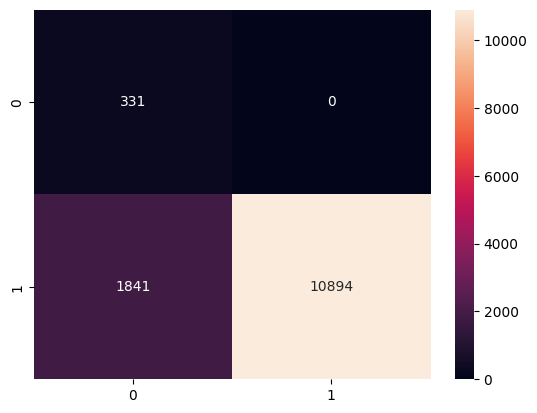

In [ ]:
conf_mat = confusion_matrix(y_cl_t, y_pred_bin)
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.show()

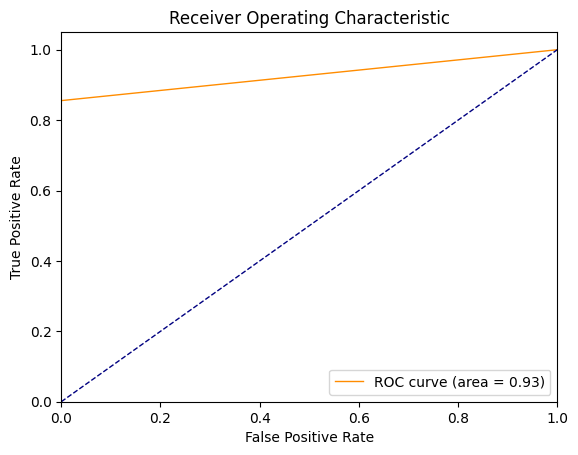

In [ ]:
fpr, tpr, thresholds = roc_curve(y_cl_t, y_pred_bin)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# **LSTM**

# **Regression**

In [ ]:
model_reg = keras.Sequential()
model_reg.add(keras.layers.LSTM(64, input_shape=(30, 17), return_sequences=True, activation="tanh"))
model_reg.add(keras.layers.LSTM(64, activation="tanh", return_sequences=False))
model_reg.add(keras.layers.Dense(16, activation='relu'))
model_reg.add(keras.layers.Dense(8, activation='relu'))
model_reg.add(keras.layers.Dense(1, activation='linear'))

In [ ]:
model_reg.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 30, 64)            20992     
                                                                 
 lstm_13 (LSTM)              (None, 64)                33024     
                                                                 
 dense_24 (Dense)            (None, 16)                1040      
                                                                 
 dense_25 (Dense)            (None, 8)                 136       
                                                                 
 dense_26 (Dense)            (None, 1)                 9         
                                                                 
Total params: 55201 (215.63 KB)
Trainable params: 55201 (215.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model_reg.compile(optimizer=RMSprop(), loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
model_reg.fit(X,y_reg, epochs=100, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/100
580/580 [==============================] - 17s 25ms/step - loss: 3317.9841 - val_loss: 1913.5387
Epoch 2/100
580/580 [==============================] - 13s 23ms/step - loss: 1892.6796 - val_loss: 1860.9911
Epoch 3/100
580/580 [==============================] - 14s 25ms/step - loss: 1892.0632 - val_loss: 1884.3495
Epoch 4/100
580/580 [==============================] - 14s 24ms/step - loss: 1891.8215 - val_loss: 1862.2469
Epoch 5/100
580/580 [==============================] - 14s 24ms/step - loss: 1889.1335 - val_loss: 1572.9481
Epoch 6/100
580/580 [==============================] - 13s 22ms/step - loss: 711.9664 - val_loss: 315.0124
Epoch 7/100
580/580 [==============================] - 13s 23ms/step - loss: 320.2297 - val_loss: 537.3472
Epoch 8/100
580/580 [==============================] - 12s 21ms/step - loss: 248.4913 - val_loss: 243.4099
Epoch 9/100
580/580 [==============================] - 13s 22ms/step - loss: 213.1290 - val_loss: 214.8579
Epoch 10/100
580/580 [=====

In [ ]:
y_pred = model_reg.predict(xx_test)
mse = mean_squared_error(y_cl_t, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_cl_t, y_pred)
mape = np.mean(np.abs((y_cl_t - y_pred) / y_cl_t)) * 100
print(f'MSE: {mse}, RMSE: {rmse}, MAE: {mae}, MAPE: {mape}%')

409/409 [==============================] - 4s 8ms/step
MSE: 1455.902166629956, RMSE: 38.15628606966296, MAE: 30.104220332959592, MAPE: 29.685043316986214%


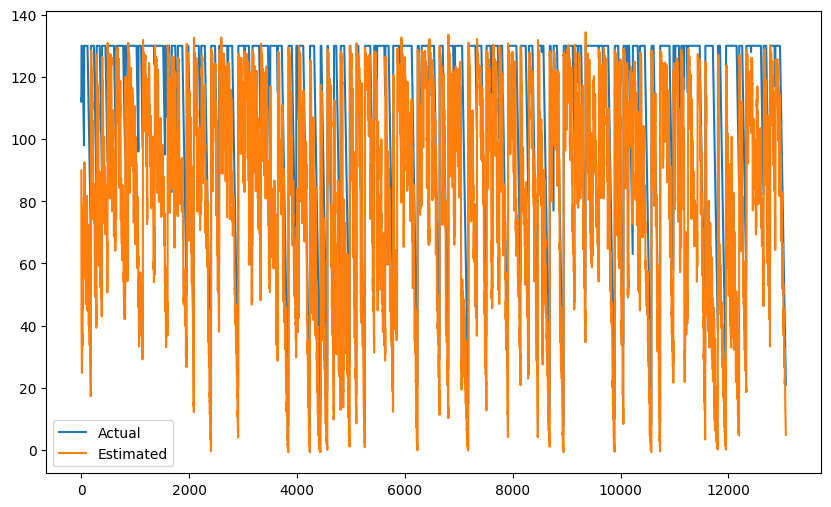

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(Y_test, label='Actual')
plt.plot(y_pred, label='Estimated')
plt.legend()
plt.show()

# **Classification**

In [ ]:
model_cla = keras.Sequential()
model_cla.add(keras.layers.LSTM(64, input_shape=(30, 17), return_sequences=True, activation="tanh"))
model_cla.add(keras.layers.LSTM(64, activation="tanh", return_sequences=False))
model_cla.add(keras.layers.Dense(8, activation='relu'))
model_cla.add(keras.layers.Dense(8, activation='relu'))
model_cla.add(keras.layers.Dense(1, activation='sigmoid'))

In [ ]:
tf.keras.utils.plot_model(model=model_cla, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [ ]:
model_cla.compile(optimizer=RMSprop(), loss='binary_crossentropy')
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

history = model_cla.fit(X, y_cl, epochs=100, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/100
580/580 [==============================] - 16s 23ms/step - loss: 0.1688 - val_loss: 0.0928
Epoch 2/100
580/580 [==============================] - 13s 23ms/step - loss: 0.0835 - val_loss: 0.0903
Epoch 3/100
580/580 [==============================] - 13s 23ms/step - loss: 0.0701 - val_loss: 0.1016
Epoch 4/100
580/580 [==============================] - 14s 24ms/step - loss: 0.0658 - val_loss: 0.0711
Epoch 5/100
580/580 [==============================] - 15s 25ms/step - loss: 0.0625 - val_loss: 0.0747
Epoch 6/100
580/580 [==============================] - 13s 22ms/step - loss: 0.0593 - val_loss: 0.0699
Epoch 7/100
580/580 [==============================] - 14s 24ms/step - loss: 0.0584 - val_loss: 0.0541
Epoch 8/100
580/580 [==============================] - 14s 25ms/step - loss: 0.0570 - val_loss: 0.0518
Epoch 9/100
580/580 [==============================] - 14s 24ms/step - loss: 0.0557 - val_loss: 0.0718
Epoch 10/100
580/580 [==============================] - 14s 24ms/step - l

In [ ]:
y_pred_bin = model_cla.predict(xx_test).round()
print(classification_report(y_cl_t, y_pred_bin))

409/409 [==============================] - 4s 9ms/step
              precision    recall  f1-score   support

           0       0.27      1.00      0.42       331
           1       1.00      0.93      0.96     12735

    accuracy                           0.93     13066
   macro avg       0.63      0.96      0.69     13066
weighted avg       0.98      0.93      0.95     13066



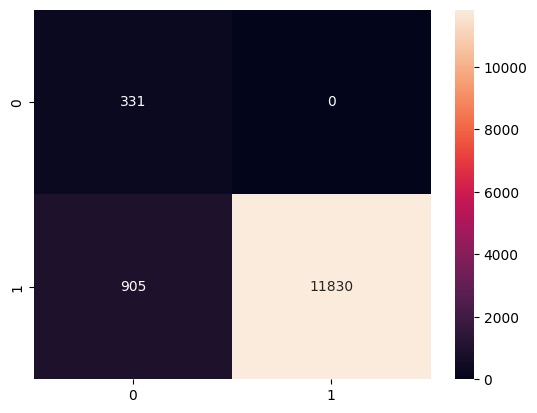

In [ ]:
conf_mat = confusion_matrix(y_cl_t, y_pred_bin)
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.show()

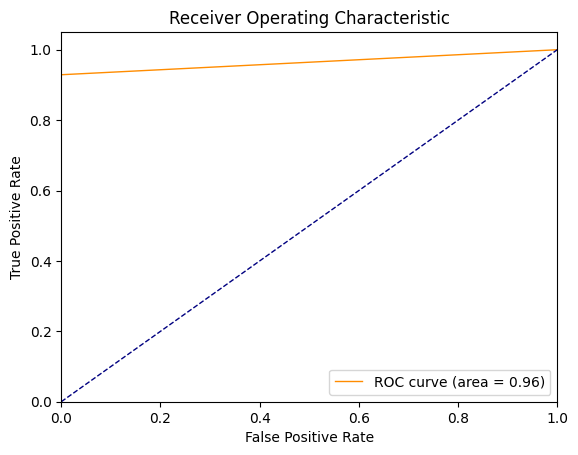

In [ ]:
fpr, tpr, thresholds = roc_curve(y_cl_t, y_pred_bin)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()